# MNIST classification with CNN  

## Introduction 

A Convolutinoal Neural Network (CNN) is a type of feed-forward architexture. Modern CNN architectures usually consist of convolutinoal layers, max pooling layers, dropout layers and fully-connected layers. In convolutional layers, individual neurons respond to stimuli in a restricted region of space known as the receptive field, which partially overlap such that they tile the visual field. Typiaclly a response is constructed by a receptive field and a weight-sharing filter with an operation called convolution. Convolutional Nerual Networks are particularly good at handling spatial data, as compared to Recurrent Neural Networks (RNN) for sequential data. 

<img src="image/typical_cnn.png">
<p align="center"> A typical Convolutional Neural Network, image credit to https://en.wikipedia.org/wiki/File:Typical_cnn.png </p>

Each feature map comes with a fitler which is a matrix of weights. Convolution is performed as a element-wise inner product between the values in a receptive field and the filter weights (with matching dimensions). By applying convolution on all receptive fields on the current layer (and then apply an activation function), a feature map/convolutional layer is derived.   

<img src="image/conv_layer.png", width=300px>
<p align="center"> Convolution on a receptive field, image credit to https://en.wikipedia.org/wiki/File:Conv_layer.png </p>

Typically, convolutional layers will be followed by pooling layers. Pooling is a way to reduce layer sizes by performing merges on near-by data fields. Popular pooling techniques include averge pooling, max pooling and one can customize pooling on data fields of various fashions (sizes, strides, paddings). Pooling is essential in extracting useful features from convolutional layers and accelerating the training process.  

<img src="image/max_pooling.png", width=300px>
<p align="center"> Max Pooling, image credit to https://en.wikipedia.org/wiki/File:Max_pooling.png </p>

## CNN in TensorFlow 

There are well-documented tutorials on building a CNN on the MNIST dataset on TensorFlow's tutorial page. Please go through it before moving on.

TensorFlow tutorials 
- "Deep MNIST for Experts", simple CNN model. (https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/#a1)
-  "TensorFlow Mechanics 101", better code organization, incoporated with TensorBoard.  (https://www.tensorflow.org/get_started/mnist/mechanics)

Some important take-aways include the <a href="https://www.tensorflow.org/api_docs/python/tf/nn/conv2d"> tf.nn.conv2d </a> and <a href="https://www.tensorflow.org/api_docs/python/tf/nn/max_pool"> tf.nn.max_pool </a> functions which are used to instantiate a 2 dimensional convolutional layer and a max pooling layer. Then a stack of convolutional layers and max pooling layers (with a final dropout layer at the top) can be grouped into a convolutional layer block.

In [1]:
import tensorflow as tf

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

## CNN in Keras

Keras is a high-level, open source nerual network library designed to enable fast experimentation with deep nerual nets. It is capable to run with Theano and TensorFlow as backend currently (maybe with Microsoft's CNTK in the future). 

We will build a CNN on MNIST using Keras, from which you can see how Keras significantly reduces the routine work to build a model and allows us to make changes/variations on the model easily.   

All the code comes with the Keras module as an example file. (https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)

In [27]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

# import keras module dependencies
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Define model hyperparameters

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28

Load MNIST image data

In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# verify data dimensions 
print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)


Most of the time, for machine learning related tasks and algorithms, image data will come in two formats: *** channels_first *** and *** channels_last ***. But gray-scale images don't have a channel dimension so the following code adds an channel dimension to the the loaded images based on the data format keras's backend currently supports. 

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# verify input shape
print("input_shape:", input_shape)

input_shape: (28, 28, 1)


*** Data preprocessing ***: 
- standardize the image pixels
- convert labels with one-hot encoding

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# verify input data 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


*** Attention: *** Be sure not to run the following cell multiple times, otherwise the y_train dimensions will keep increasing and memory will run out eventually. If it happens, restart the kernel and run all cells again.

In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# verify label data
print('y_train shape:', y_train.shape)

y_train shape: (60000, 10)


### Build model 

A sequential model in Keras, as its name suggests, consists of layers stacked on top of each other in sequence. This structure greatly simplifies the model building process as the following.

***
1. instantiate a sequential model.
2. Construct different layers by adding layer instances to the sequential model  
3. compile the model with specified optimizer, loss function and metric(s)
4. train the model 
***

We don't have to worry about define layer weights and biases, since Keras will construct those variable upon compilation with its auto-inferrence mechanism. And it is not necessary to assign layers instances, inputs or outputs to individual variables (although you could), since we will be able to retrieve them after the model is compiled and trained. Cheers for the power of Keras !

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Model compilation simply configures the learning process, but it encapsulates operations for linking with an optimizer, loss function compared to using pure TensorFlow where you need to explicitly define those operations and run them on your own.  

Here we use categorical crossentropy for loss and the Adadelta optimizer. Typically you will use "accuracy" for metrics but you can always customize your own. See https://keras.io/metrics/ for more details.

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Training a model with only one line! The <a href="https://keras.io/metrics/"> "model.fit" </a> function takes the processed image and label data, along with some other pre-defined model hyperparameter to start training. After training, the model object will include the model architecture and trained weights, and you can easily save it to disk or use it to make predictions.   

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
12160/60000 [=====>........................] - ETA: 200s - loss: 0.7792 - acc: 0.7576

## Evaluate the model 

The <a href="https://keras.io/models/sequential/">"model.evaluate"</a> function provides a straight-forward way to evaluate the model given the test set. Turn on verbose mode (setting "verbose=1") if you want to monitor the built-in test logging messages. 

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

KeyboardInterrupt: 

## Make predictions 

In order to make predictions, you can use the <a href="https://keras.io/models/sequential/"> "model.predict" </a> function, which will return a Numpy array of predictions. 

In [18]:
# taking a batch from the training set samples for prediction
images = x_train[:50]
# print(images.shape)

In [25]:
# make preditions using the trained model.
pred = model.predict(images)
prediction = np.argmax(pred, 1)    # compress one-hot encoding into an integer from prediction results 

# verify predicted output
print(prediction.shape)

(50,)


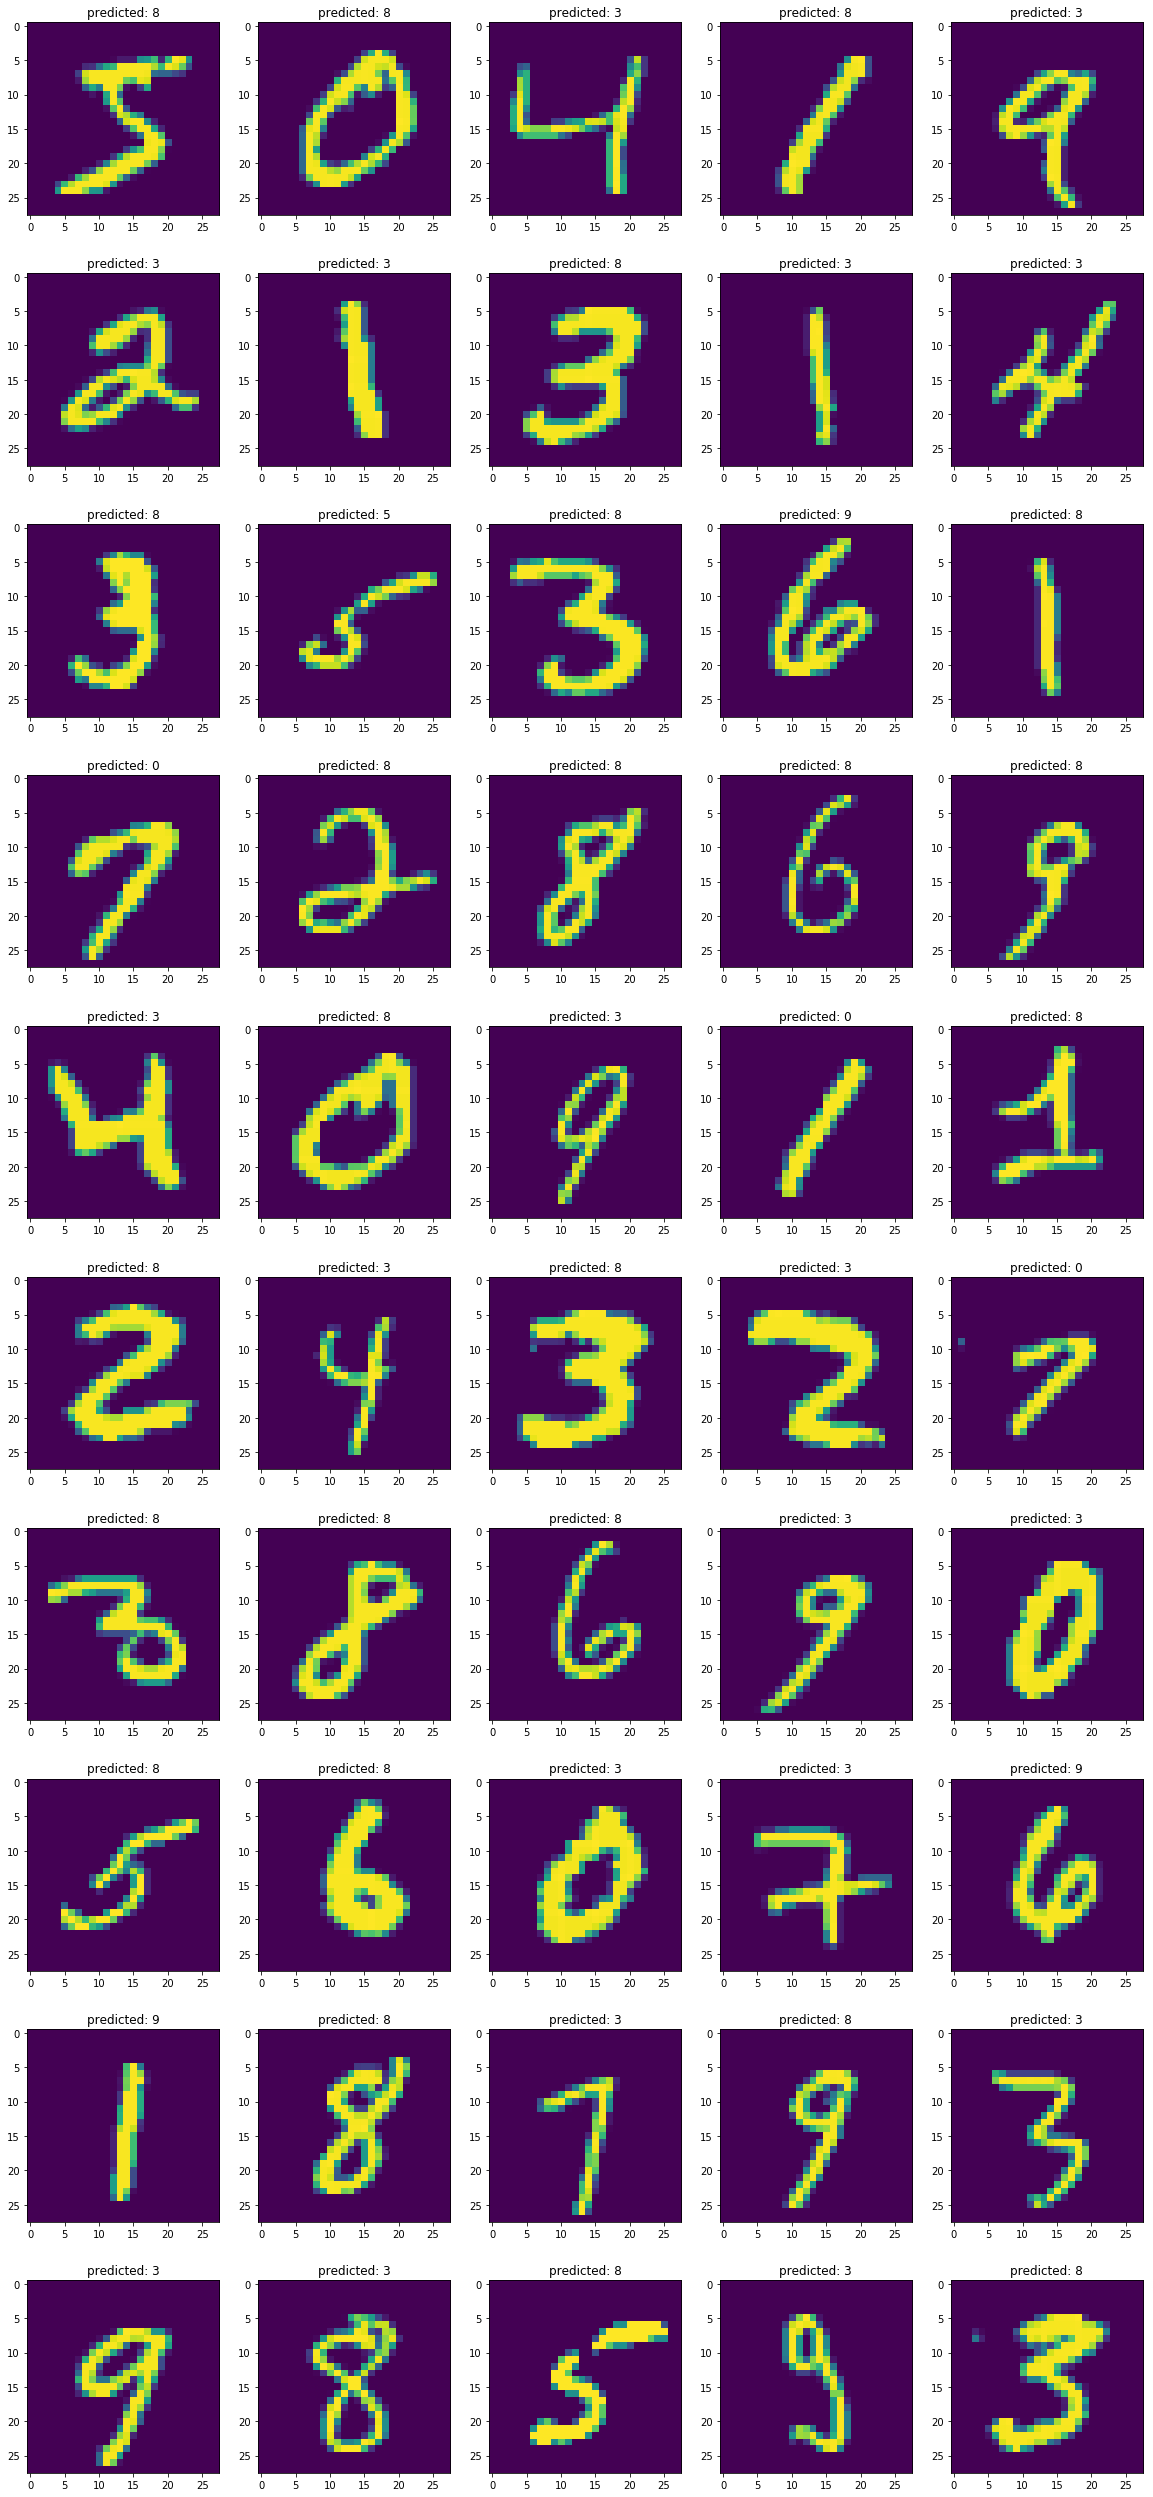

In [26]:
# plot the results
plt.figure(figsize=(20, 50))
for i in range(prediction.shape[0]):
    plt.subplot(int(prediction.shape[0] / 5) + 1, 5, i+1)
    img = np.reshape(images[i], (28, 28))
    plt.imshow(img)
    plt.title("predicted: %d" % prediction[i])
    
plt.show()  

# Great job coming so far. Keep the good work and move on !